In [5]:
import pandas as pd
import numpy as np

import tensorflow as tf


import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler

%matplotlib inline

In [6]:
df = pd.read_csv('E:/Local Disk/datasets/Monthly-milk-production.csv',index_col='Month')
df.index = pd.to_datetime(df.index)
df.head(2)


,Milk Production
Month,
1962-01-01 01:00:00,589
1962-02-01 01:00:00,561


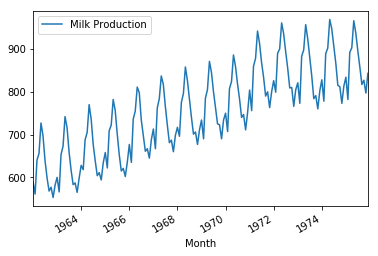

In [15]:
df.plot()

In [7]:

df.info()


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 168 entries, 1962-01-01 01:00:00 to 1975-12-01 01:00:00
Data columns (total 1 columns):
Milk Production    168 non-null int64
dtypes: int64(1)
memory usage: 2.6 KB


In [8]:
df.describe()

,Milk Production
count,168.000000
mean,754.708333
std,102.204524
min,553.000000
25%,677.750000
50%,761.000000
75%,824.500000
max,969.000000


In [17]:
df.isnull().sum()

Milk Production    0
dtype: int64

In [10]:
scalar = MinMaxScaler()
Train = df.head(156)
Test = df.tail(12)

Train_Scalar = scalar.fit_transform(Train)
Test_Scalar = scalar.fit_transform(Test)


In [11]:
def next_batch(training_data, batch_size, steps):
    
    # Grab a random starting point for each batch
    rand_start = np.random.randint(0,len(training_data)-steps) 

    # Create Y data for time series in the batches
    y_batch = np.array(training_data[rand_start:rand_start+steps+1]).reshape(1,steps+1)
    
    x_batch = y_batch[:, :-1].reshape(-1, steps, 1)    # Date  Shape Batch Timestep inputdim
    y_batch = y_batch[:, 1:].reshape(-1, steps, 1)     # Price STock
    return x_batch , y_batch

In [12]:

num_inputs = 1
num_time_steps = 12
num_neurons = 100
num_outputs = 1
learning_rate = 0.01 
num_train_iterations = 4000
batch_size = 1

X = tf.placeholder(tf.float32, [None, num_time_steps, num_inputs])
y = tf.placeholder(tf.float32, [None, num_time_steps, num_outputs])


# Also play around with GRUCell
cell = tf.contrib.rnn.OutputProjectionWrapper(
    tf.contrib.rnn.GRUCell(num_units=num_neurons, activation=tf.nn.relu),
    output_size=num_outputs)

output, state = tf.nn.dynamic_rnn(cell, X, dtype=tf.float32)

loss = tf.reduce_mean(tf.square(output - y)) # MSE
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
train = optimizer.minimize(loss)
init = tf.global_variables_initializer()

saver = tf.train.Saver()


with tf.Session() as sess:
    sess.run(init)
    
    for iteration in range(num_train_iterations):
        
        X_batch, y_batch = next_batch(Train_Scalar, batch_size,num_time_steps)
        sess.run(train, feed_dict={X: X_batch, y: y_batch})
        
        if iteration % 100 == 0:
            
            mse = loss.eval(feed_dict={X: X_batch, y: y_batch})
            print(iteration, "\tMSE:", mse)
        saver.save(sess, "./ex_time_series_soumil")


The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

Instructions for updating:
This class is equivalent as tf.keras.layers.GRUCell, and will be replaced by that in Tensorflow 2.0.
Instructions for updating:
Please use `keras.layers.RNN(cell)`, which is equivalent to this API
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
0 	MSE: 0.08019087
100 	MSE: 0.013863412
200 	MSE: 0.00831

In [13]:
Test

,Milk Production
Month,
1975-01-01 01:00:00,834
1975-02-01 01:00:00,782
1975-03-01 01:00:00,892
1975-04-01 01:00:00,903
1975-05-01 01:00:00,966
1975-06-01 01:00:00,937
1975-07-01 01:00:00,896
1975-08-01 01:00:00,858
1975-09-01 01:00:00,817


In [18]:
with tf.Session() as sess:
    saver.restore(sess, "./ex_time_series_soumil")
    train_seed = list(Train_Scalar[-12:])

    for iteration in range(12):
        X_batch = np.array(train_seed[-num_time_steps:]).reshape(1, num_time_steps, 1)
        y_pred = sess.run(output, feed_dict={X: X_batch})
        train_seed.append(y_pred[0, -1, 0])

Instructions for updating:
Use standard file APIs to check for files with this prefix.
INFO:tensorflow:Restoring parameters from ./ex_time_series_soumil


In [19]:
results = scalar.inverse_transform(np.array(train_seed[12:]).reshape(12,1))


In [20]:
len(results)


12

In [21]:
results

array([[901.14667],
       [889.5263 ],
       [924.1958 ],
       [926.3966 ],
       [935.1949 ],
       [923.1915 ],
       [915.8782 ],
       [900.2781 ],
       [894.0123 ],
       [883.8141 ],
       [889.16394],
       [891.9835 ]], dtype=float32)

In [22]:
Test["Predicted"]  = results


c:\users\dell\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [25]:
Test

,Milk Production,Predicted
Month,,
1975-01-01 01:00:00,834,901.146667
1975-02-01 01:00:00,782,889.526306
1975-03-01 01:00:00,892,924.195801
1975-04-01 01:00:00,903,926.396606
1975-05-01 01:00:00,966,935.194885
1975-06-01 01:00:00,937,923.191528
1975-07-01 01:00:00,896,915.878174
1975-08-01 01:00:00,858,900.278076
1975-09-01 01:00:00,817,894.012329


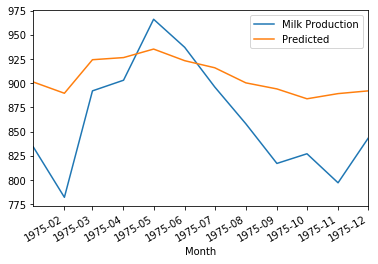

In [26]:

Test.plot()